In [4]:
import cv2
import torch
import numpy as np
def histogram_equalization(img):
    """
    对图像进行直方图均衡化
    参数:
        img: 输入图像(RGB或灰度)
    返回:
        equalized_img: 均衡化后的图像
        hist_original: 原始图像直方图
        hist_equalized: 均衡化后直方图
    """
    if len(img.shape) == 3:  # 彩色图像
        # 转换为YCrCb空间，只对Y通道(亮度)进行均衡化
        ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        y = ycrcb[:,:,0]
        
        # 计算原始直方图
        hist_original = cv2.calcHist([y], [0], None, [256], [0,256])
        # 均衡化
        y_eq = cv2.equalizeHist(y)
        # 合并通道
        ycrcb[:,:,0] = y_eq
        equalized_img = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
        
        # 计算均衡化后直方图
        hist_equalized = cv2.calcHist([y_eq], [0], None, [256], [0,256])
    else:  # 灰度图像
        hist_original = cv2.calcHist([img], [0], None, [256], [0,256])
        equalized_img = cv2.equalizeHist(img)
        hist_equalized = cv2.calcHist([equalized_img], [0], None, [256], [0,256])
    
    return equalized_img, hist_original, hist_equalized


In [5]:
def tensor_to_cv2(tensor):
    # 1. 张量 → NumPy（移除计算图，转CPU）
    img_np = tensor.detach().cpu().numpy()
    # 2. 调整维度顺序 [C, H, W] → [H, W, C]
    img_np = np.transpose(img_np, (1, 2, 0))
    # 3. 数值范围 0~1 → 0~255，并转为uint8
    img_np = (img_np * 255).astype(np.uint8)
    # 4. RGB → BGR（可选，仅当原始张量为RGB时需转换）
    # img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    return img_np

In [6]:
def binary_threshold( image,eps= 0.01, max_val= 1) :

    # 检查输入类型
    input_is_tensor = isinstance(image, torch.Tensor)
    input_is_ndarray = isinstance(image, np.ndarray)
    if not (input_is_tensor or input_is_ndarray):
        raise TypeError("输入必须是 torch.Tensor 或 numpy.ndarray")
    
    # 转换为灰度图
    if input_is_tensor:
        if image.ndim == 3:
            # 使用加权平均法将 RGB 转为灰度 (PyTorch)
            if image.shape[0] == 3:  # CHW 格式
                gray = (0.299 * image[0] + 0.587 * image[1] + 0.114 * image[2])
            else:  # HWC 格式
                gray = (0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2])
        elif image.ndim == 2:
            gray = image
        else:
            raise ValueError("输入张量的形状必须是 (H,W) 或 (C,H,W) 或 (H,W,C)")
    else:  # numpy.ndarray
        if image.ndim == 3:
            # 使用加权平均法将 RGB 转为灰度 (NumPy)
            if image.shape[2] == 3:  # HWC 格式
                gray = (0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2])
            else:  # CHW 格式
                gray = (0.299 * image[0] + 0.587 * image[1] + 0.114 * image[2])
        elif image.ndim == 2:
            gray = image
        else:
            raise ValueError("输入数组的形状必须是 (H,W) 或 (H,W,3) 或 (3,H,W)")
    
    # 二值化
    if input_is_tensor:
        binary = (gray > eps).to(gray.dtype) * max_val
    else:
        binary = (gray > eps).astype(image.dtype) * max_val
    return binary

Base Image Loaded with examples: 9689
Scattering Flare Image: E:/dataset/Flare7Kpp/Flare7K  is loaded successfully with examples 5000
Now we have 5000 scattering flare images
Light Source Image: E:/dataset/Flare7Kpp/Flare7K  is loaded successfully with examples 5000
Now we have 5000 light source images
ERROR: reflective flare images are not loaded properly
Now we have 1 refelctive flare images


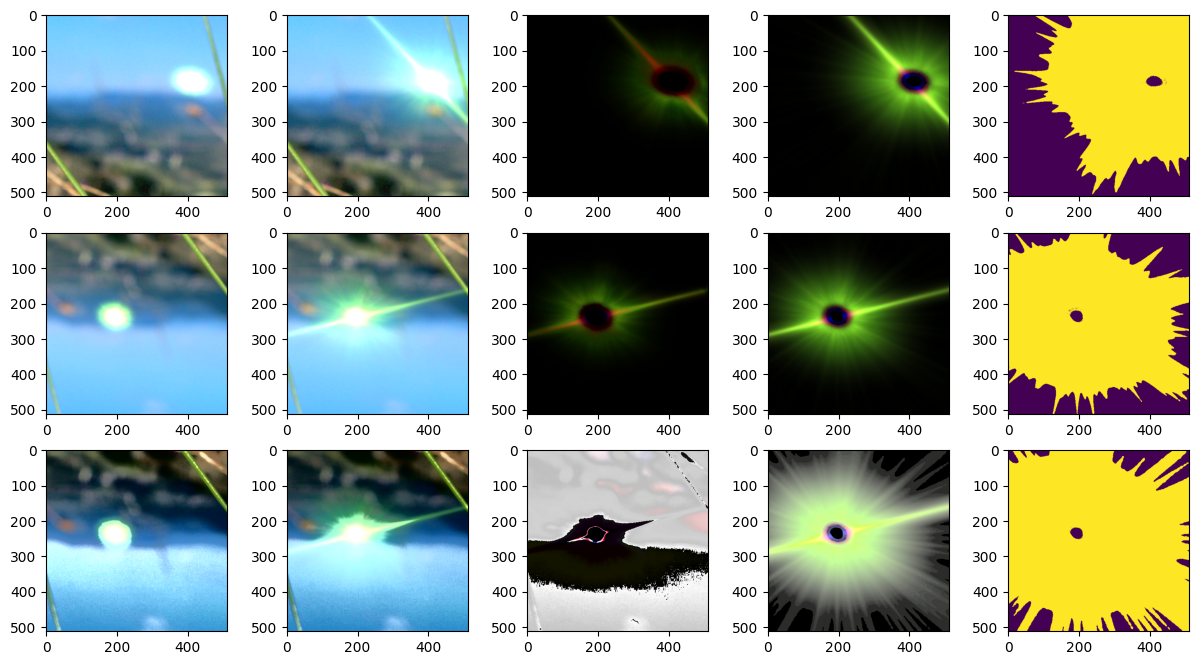

In [19]:
from flare7kpp_dataloader import Flare_Image_Loader
from matplotlib import pyplot as plt

transform_base= {
	'img_size': 512
}

transform_flare= {
    "scale_min": 0.8,
    "scale_max": 1.5,
    "translate": 300,
    "shear": 20           
}

flare_image_loader=Flare_Image_Loader('E:/dataset/Flickr24K',transform_base,transform_flare,mask_type='luminance')
flare_image_loader.load_scattering_flare('E:/dataset/Flare7Kpp/Flare7K','E:/dataset/Flare7Kpp/Flare7K/Scattering_Flare/Compound_Flare')
flare_image_loader.load_light_source('E:/dataset/Flare7Kpp/Flare7K','E:/dataset/Flare7Kpp/Flare7K/Scattering_Flare/Light_Source')
# flare_image_loader.load_scattering_flare('E:/dataset/Flare7Kpp/Flare7K','E:/dataset/Flare7Kpp/Flare-R/Compound_Flare')
# flare_image_loader.load_light_source('E:/dataset/Flare7Kpp/Flare7K','E:/dataset/Flare7Kpp/Flare-R/Light_Source')
flare_image_loader.load_reflective_flare('E:/dataset/Flare7Kpp/Flare7K','E:/dataset/Flare7Kpp/Flare7K/Reflective_Flare')

# flare_image_loader.load_lightsource('E:/dataset/Flare7Kpp/Flare7K','E:/dataset/Flare7Kpp/Flare7K/Scattering_Flare/Core')
# img_index= random.randint(0,len(flare_image_loader)-1)
img_index= 99
# test_base_img,test_flare_img,test_merge_img,flare_mask=flare_image_loader[img_index]
dic = flare_image_loader[img_index]
test_base_img,test_merge_img,msk1 = dic['gt'], dic['lq'], dic['flare']
img_index= 99
# test_base_img,test_flare_img,test_merge_img,flare_mask=flare_image_loader[img_index]
dic = flare_image_loader[img_index]
test_base_img2,test_merge_img2,msk2 = dic['gt'], dic['lq'], dic['flare']

fig, axes = plt.subplots(3, 5, figsize=(15, 8))
max_display_size = (64, 64)  # 控制显示大小
axes[0, 0].imshow(test_base_img.permute(1,2,0))
axes[0, 1].imshow(test_merge_img.permute(1,2,0))
axes[0, 2].imshow(torch.clamp(test_merge_img-test_base_img,0,1).permute(1,2,0))
axes[0, 3].imshow(msk1.permute(1,2,0))
axes[0, 4].imshow(binary_threshold(msk1.permute(1,2,0)))
axes[1, 0].imshow(test_base_img2.permute(1,2,0))
axes[1, 1].imshow(test_merge_img2.permute(1,2,0))
axes[1, 2].imshow(torch.clamp(test_merge_img2-test_base_img2,0,1).permute(1,2,0))
axes[1, 3].imshow(msk2.permute(1,2,0))
axes[1, 4].imshow(binary_threshold(msk2.permute(1,2,0)))
test_base_img2 = tensor_to_cv2(test_base_img2)
test_base_img2_eq,_,_ = histogram_equalization(test_base_img2)
test_merge_img2 = tensor_to_cv2(test_merge_img2)
test_merge_img2_eq,_,_ = histogram_equalization(test_merge_img2)
msk2 = tensor_to_cv2(msk2)
msk2_eq,_,_ = histogram_equalization(msk2)
axes[2, 0].imshow(test_base_img2_eq)
axes[2, 1].imshow(test_merge_img2_eq)
axes[2, 2].imshow(test_merge_img2_eq-test_merge_img2)
axes[2, 3].imshow(msk2_eq)
axes[2, 4].imshow(binary_threshold(msk2_eq,eps=3,max_val=255))


In [18]:
img_index= 99
dic = flare_image_loader[img_index]
test_base_img,test_merge_img,msk1 = dic['gt'], dic['lq'], dic['flare']



In [ ]:
import torch.nn as nn
class FourDirectionalConv(nn.Module):
    def __init__(self, in_channels, out_channels,padding=0,stride=1):
        super(FourDirectionalConv, self).__init__()
        self.horizontal = torch.nn.Parameter(torch.randn((1,in_channels)),requires_grad=True)
        self.vertical = torch.nn.Parameter


    def forward(self, x):
        x1 = self.conv1(x)  # 正向
        x2 = self.conv2(torch.flip(x, [2]))  # 水平翻转
        x3 = self.conv3(torch.flip(x, [3]))  # 垂直翻转
        x4 = self.conv4(torch.flip(x, [2, 3]))  # 水平垂直翻转
        return x1 + torch.flip(x2, [2]) + torch.flip(x3, [3]) + torch.flip(x4, [2, 3])

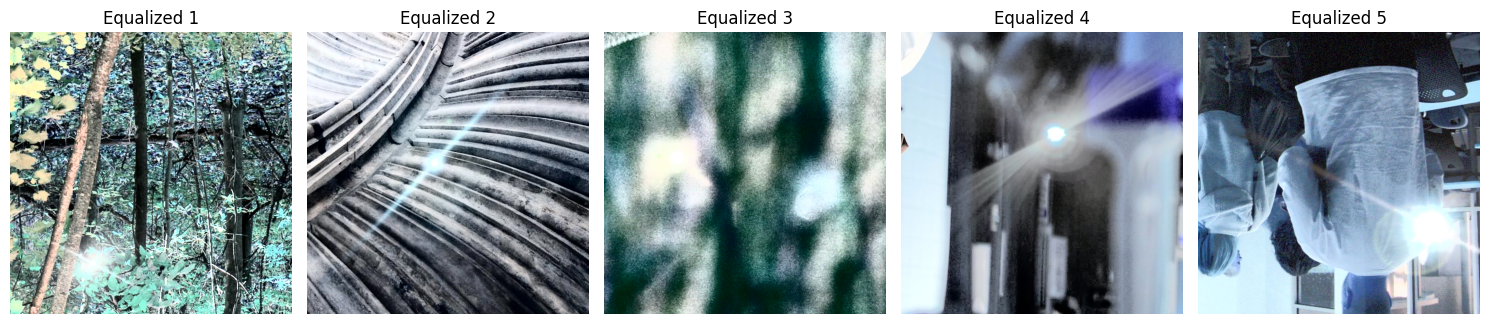

In [23]:



import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

def generate_flare_mask(rgb_image, gamma=0.4, threshold=180):
    """生成耀斑掩码（耀斑为白色，其余为黑色）"""
    gray = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    inv_gamma = 1.0 / gamma
    gamma_corrected = np.power(gray / 255.0, inv_gamma) * 255
    gamma_corrected = gamma_corrected.astype(np.uint8)
    _, mask = cv2.threshold(gamma_corrected, threshold, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # 闭运算填充小孔
    return mask

def load_and_process_images(folder_path, num_samples=5):
    """从文件夹加载图片，随机选择5张并生成掩码"""
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    original_images = []
    equalized_images = []
    mask_images = []
    
    for file in selected_files:
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转为RGB供Matplotlib显示
        mask = generate_flare_mask(img)
        equalized,_,_ = histogram_equalization(img)
        original_images.append(img_rgb)
        mask_images.append(mask)
        equalized_images.append(equalized)
    
    return original_images, mask_images, equalized_images

def plot_results(original_images, mask_images,equalized_images):
    """分两行展示原图和掩码"""
    num_images = len(original_images)
    plt.figure(figsize=(15, 9))
    
    # 第一行：原图
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.title(f"Original {i+1}")
        plt.axis('off')
    
    # # 第二行：掩码
    # for i in range(num_images):
    #     plt.subplot(2, num_images, num_images + i + 1)
    #     plt.imshow(mask_images[i], cmap='gray')
    #     plt.title(f"Mask {i+1}")
    #     plt.axis('off')
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(equalized_images[i])
        plt.title(f"Equalized {i+1}")
        plt.axis('off')

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(equalized_images[i]-original_images[i])
        plt.title(f"Original {i+1}")
        plt.axis('off')
    #     
    plt.tight_layout()
    plt.show()

# 使用示例
folder_path = "E:/dataset/flare7kpp_r_local/input/c0"  # 替换为你的图片文件夹路径
original_images, mask_images, equalized_images = load_and_process_images(folder_path)
plot_results(original_images, mask_images, equalized_images)

In [55]:
# 导入必要的库
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# 设置matplotlib在Notebook中显示
%matplotlib inline

# 1. 读取图片
# 请将图片路径替换为您自己的图片路径
image_path = 'E:/dataset/flare7kpp_r_local/input/c2/30.png'  # 修改为您的图片路径
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式

# 检查图片是否成功加载
if original_image is None:
    raise ValueError("图片加载失败，请检查路径是否正确")

# 2. 定义Gamma变换函数
def gamma_correction(img, gamma=1.0):
    # 应用Gamma变换
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

# 3. 定义处理函数，用于显示所有图像
def process_and_display(gamma=1.0, threshold=30):
    # 应用Gamma变换
    gamma_image = gamma_correction(original_image, gamma)
    
    # 计算两图的绝对差异
    diff_image = cv2.absdiff(original_image, gamma_image)
    
    # 将差异图像转换为灰度图以便阈值处理
    diff_gray = cv2.cvtColor(diff_image, cv2.COLOR_RGB2GRAY)
    
    # 找到受影响小的区域（低于阈值）
    _, low_change_mask = cv2.threshold(diff_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    low_change_region = cv2.bitwise_and(original_image, original_image, mask=low_change_mask)
    
    # 计算原图与低变化区域的差异
    diff_with_low_change = cv2.absdiff(original_image, low_change_region)
    
    # 创建图形和子图
    fig, axes = plt.subplots(1, 5, figsize=(12, 5))
    
    # 显示原图
    axes[0].imshow(original_image)
    axes[0].set_title('origin')
    axes[0].axis('off')
    
    # 显示Gamma变换后的图像
    axes[1].imshow(gamma_image)
    axes[1].set_title(f'Gamma (γ={gamma})')
    axes[1].axis('off')
    
    # 显示差异图像
    axes[2].imshow(255-diff_image)
    axes[2].set_title('res')
    axes[2].axis('off')
    
    # 显示受影响小的区域
    axes[3].imshow(low_change_region)
    axes[3].set_title(f'least attected (low={threshold})')
    axes[3].axis('off')
    
    # 显示原图与低变化区域的差异
    # axes[4].imshow(diff_with_low_change)
    axes[4].imshow(diff_with_low_change)
    axes[4].set_title('res')
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()

# 4. 创建交互式控件
interact(process_and_display, 
         gamma=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.2, description='Gamma'),
         threshold=FloatSlider(min=1, max=100, step=1, value=30, description='threshold'))

interactive(children=(FloatSlider(value=1.2, description='Gamma', max=5.0, min=0.1), FloatSlider(value=30.0, d…

<function __main__.process_and_display(gamma=1.0, threshold=30)>

In [8]:
import torch
import torch.nn as nn
import torch.fft
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# -------------------------
# 读取全彩图像 (RGB)，转为张量 [3,H,W]
# -------------------------
img_path = "E:/dataset/Flare7Kpp/test_data/real/input/input_000039.png"  # 修改为你的图片路径
img = Image.open(img_path).convert("RGB")
transform = T.ToTensor()
img_tensor = transform(img)  # shape: (3, H, W)

C, H, W = img_tensor.shape
yy, xx = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="ij")
center_y, center_x = H // 2, W // 2
dist = torch.sqrt((yy - center_y)**2 + (xx - center_x)**2)

# -------------------------
# 可学习滤波器（独立初始化）
# -------------------------
class GaussianFilter(nn.Module):
    def __init__(self, H, W):
        super().__init__()
        self.H, self.W = H, W

    def forward(self, f_img_shift, sigma_lp, sigma_hp):
        # Gaussian LPF
        lp_mask = torch.exp(-(dist**2) / (2*(sigma_lp**2)))
        # Gaussian HPF
        hp_mask = 1 - torch.exp(-(dist**2) / (2*(sigma_hp**2)))

        lp = lp_mask.unsqueeze(0)
        hp = hp_mask.unsqueeze(0)
        br = lp+hp
        bp = 1-br

        low_f = f_img_shift * lp
        high_f = f_img_shift * hp
        br_f = f_img_shift * br
        bp_f = f_img_shift * bp
        return low_f, high_f, br_f,bp_f

# -------------------------
# 傅里叶变换 (对3通道分别做)
# -------------------------
f_img = torch.fft.fft2(img_tensor)          # [3,H,W]
f_img_shift = torch.fft.fftshift(f_img)     # [3,H,W]

# 定义滤波器
filt = GaussianFilter(H, W)

# -------------------------
# 逆傅里叶变换
# -------------------------
def ifft_img(f_comp):
    f_ishift = torch.fft.ifftshift(f_comp)
    img_back = torch.fft.ifft2(f_ishift).real
    return img_back.clamp(0, 1)  # 保证像素范围

# -------------------------
# 动态交互函数
# -------------------------
def show_filtered(sigma_lp=20, sigma_hp=40):
    low_f, high_f, br_f,bp_f = filt(f_img_shift, sigma_lp, sigma_hp)
    img_low = ifft_img(low_f)
    img_high = ifft_img(high_f)
    img_br = ifft_img(br_f)
    img_bp = ifft_img(bp_f)

    plt.figure(figsize=(15, 5))
    titles = ["Original", f"low pass (σ={sigma_lp})", 
              f"high pass (σ={sigma_hp})", "band reject", "band pass"]
    images = [img_tensor, img_low, img_high, img_br,img_bp]

    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].permute(1, 2, 0).detach().cpu())
        plt.title(titles[i])
        plt.axis("off")

    plt.show()

# -------------------------
# 使用滑块交互调节高斯滤波半径
# -------------------------
interact(show_filtered,
         sigma_lp=IntSlider(min=1, max=min(H,W)//2, step=5, value=20),
         sigma_hp=IntSlider(min=1, max=min(H,W)//2, step=5, value=40));


interactive(children=(IntSlider(value=20, description='sigma_lp', max=256, min=1, step=5), IntSlider(value=40,…